In [1]:
"""
Advanced High-Risk Account Detection for Anti-Money Laundering
Uses Graph Neural Networks and Behavioral Feature Engineering
"""
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve, auc, roc_curve
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool, SAGEConv, global_mean_pool
from torch_geometric.data import NeighborSampler
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data, DataLoader as PyGDataLoader
import networkx as nx
from collections import defaultdict
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [2]:
from tqdm import tqdm
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent.parent))  # Adjust as needed
from config import DATAPATH, SAMPLE_DATAPATH

In [3]:
# Load the entire dataset
df = pd.read_csv(DATAPATH)

# Filter by data range
# df = df[df['Date'] < '2023-02-28']

In [4]:
print("\n" + "="*70)
print("TRANSACTION-LEVEL STATISTICS")
print("="*70)
print(f"Total transactions: {len(df):,}")
print(f"Suspicious transactions: {df['Is_laundering'].sum():,} ({df['Is_laundering'].mean()*100:.2f}%)")
print(f"Unique senders: {df['Sender_account'].nunique():,}")
print(f"Unique receivers: {df['Receiver_account'].nunique():,}")


TRANSACTION-LEVEL STATISTICS
Total transactions: 9,504,852
Suspicious transactions: 9,873 (0.10%)
Unique senders: 292,715
Unique receivers: 652,266


In [5]:
# Add and delete columns
df['DateTime'] = pd.to_datetime(df["Date"] + ' ' + df["Time"], format='%Y-%m-%d %H:%M:%S')

# df.drop(columns=['Laundering_type'], inplace=True)
df.drop(columns=['Time', 'Date'], inplace=True)

print("\nDate range:")
print(f"From: {df['DateTime'].min()}")
print(f"To: {df['DateTime'].max()}")


Date range:
From: 2022-10-07 10:35:19
To: 2023-08-23 10:57:12


## 3. Account-Level Feature Engineering

In [6]:
def extract_account_features(account, sent_txns, recv_txns):
    """
    Extract comprehensive behavioral features for an account
    """
    features = {}
    
    # === YOUR EXISTING FEATURES (keep all) ===
    # features['total_txns'] = len(sent_txns) + len(recv_txns)
    # features['sent_count'] = len(sent_txns)
    # features['recv_count'] = len(recv_txns)
    # features['sent_recv_ratio'] = len(sent_txns) / (len(recv_txns) + 1)
    
    # features['total_sent_amount'] = sent_txns['Amount'].sum()
    # features['total_recv_amount'] = recv_txns['Amount'].sum()
    # features['avg_sent_amount'] = sent_txns['Amount'].mean() if len(sent_txns) > 0 else 0
    # features['avg_recv_amount'] = recv_txns['Amount'].mean() if len(recv_txns) > 0 else 0
    # features['std_sent_amount'] = sent_txns['Amount'].std() if len(sent_txns) > 1 else 0
    # features['std_recv_amount'] = recv_txns['Amount'].std() if len(recv_txns) > 1 else 0
    features['median_sent_amount'] = sent_txns['Amount'].median() if len(sent_txns) > 0 else 0
    features['median_recv_amount'] = recv_txns['Amount'].median() if len(recv_txns) > 0 else 0
    
    # features['unique_senders'] = recv_txns['Sender_account'].nunique()
    # features['unique_receivers'] = sent_txns['Receiver_account'].nunique()
    
    # all_account_txns = pd.concat([sent_txns, recv_txns]).sort_values(by='DateTime').reset_index(drop=True)
    
    # if len(all_account_txns) > 0:
    #     all_account_txns['txn_count_1h'] = all_account_txns.rolling(window='1h', on='DateTime')['Amount'].count()
    #     all_account_txns['txn_count_24h'] = all_account_txns.rolling(window='24h', on='DateTime')['Amount'].count()
    #     all_account_txns['txn_count_7d'] = all_account_txns.rolling(window='7d', on='DateTime')['Amount'].count()
    #     all_account_txns['txn_amount_7d'] = all_account_txns.rolling(window='7d', on='DateTime')['Amount'].sum()

    #     features['max_txn_count_7d'] = all_account_txns['txn_count_7d'].max()
    #     features['max_txn_amount_7d'] = all_account_txns['txn_amount_7d'].max()

    #     baseline_daily_rate = all_account_txns['txn_count_24h'].median()
    #     features['velocity_anomaly_24h'] = all_account_txns['txn_count_24h'].max() / (baseline_daily_rate + 0.01)
    #     features['burst_ratio_1h_vs_7d'] = all_account_txns['txn_count_1h'].max() / (features['max_txn_count_7d'] / (7*24) + 0.01)
        
    # else:
    #     behavioral_features = ['max_txn_count_7d', 'max_txn_amount_7d', 'velocity_anomaly_24h', 'burst_ratio_1h_vs_7d']
    #     for feat in behavioral_features:
    #         features[feat] = 0
    
    # high_risk_countries = {'Mexico', 'Turkey', 'Morocco', 'UAE'}
    # features['sent_to_high_risk'] = sent_txns['Receiver_bank_location'].isin(high_risk_countries).sum()
    # features['recv_from_high_risk'] = recv_txns['Sender_bank_location'].isin(high_risk_countries).sum()
    # features['high_risk_ratio'] = (features['sent_to_high_risk'] + features['recv_from_high_risk']) / \
    #                              (features['total_txns'] + 1)
    
    # high_risk_payment_types = {'Cross-border'}
    # features['high_risk_payment_count'] = sent_txns['Payment_type'].isin(high_risk_payment_types).sum()
    # features['cash_usage_ratio'] = (sent_txns['Payment_type'] == 'Cash').sum() / (len(sent_txns) + 1)
    
    # # ═══════════════════════════════════════════════════════════════════
    # # NEW: 7 ADDITIONAL HIGH-IMPACT FEATURES
    # # ═══════════════════════════════════════════════════════════════════
    
    # # NEW FEATURE 1: Counterparty Diversity Score (fan-out/fan-in strength)
    # # WHY: High diversity with low repeat = classic laundering pattern
    # total_unique_counterparties = features['unique_senders'] + features['unique_receivers']
    # features['counterparty_diversity'] = total_unique_counterparties / (features['total_txns'] + 1)
    
    # # NEW FEATURE 2: Weekend Activity Ratio (unusual timing)
    # # WHY: Legitimate businesses transact weekdays; unusual weekend activity = suspicious
    # if len(all_account_txns) > 0:
    #     all_account_txns['is_weekend'] = all_account_txns['DateTime'].dt.dayofweek >= 5
    #     features['weekend_txn_ratio'] = all_account_txns['is_weekend'].sum() / len(all_account_txns)
    # else:
    #     features['weekend_txn_ratio'] = 0
    
    # # NEW FEATURE 3: Amount Concentration (Herfindahl index)
    # # WHY: Uniform amounts = structuring; concentrated = normal business
    # if len(sent_txns) > 0:
    #     receiver_amounts = sent_txns.groupby('Receiver_account')['Amount'].sum()
    #     total_sent = receiver_amounts.sum()
    #     if total_sent > 0:
    #         # Herfindahl-Hirschman Index
    #         shares = (receiver_amounts / total_sent) ** 2
    #         features['amount_concentration_hhi'] = shares.sum()
    #     else:
    #         features['amount_concentration_hhi'] = 0
    # else:
    #     features['amount_concentration_hhi'] = 0
    
    # # NEW FEATURE 4: Max Single Transaction Ratio
    # # WHY: One large transaction vs many small = different risk profile
    # if len(sent_txns) > 0:
    #     max_single_txn = sent_txns['Amount'].max()
    #     features['max_single_txn_ratio'] = max_single_txn / (features['total_sent_amount'] + 1)
    # else:
    #     features['max_single_txn_ratio'] = 0
    
    # # NEW FEATURE 5: Immediate Forward Rate (pass-through indicator)
    # # WHY: Receiving then immediately sending = mule account behavior
    # if len(all_account_txns) > 1:
    #     # For each received transaction, check if sent within 24 hours
    #     recv_times = recv_txns['DateTime'].values
    #     sent_times = sent_txns['DateTime'].values
        
    #     immediate_forwards = 0
    #     for recv_time in recv_times:
    #         # Check if any sent transaction within 24 hours after receiving
    #         time_diffs = (sent_times - recv_time).astype('timedelta64[h]').astype(float)
    #         if ((time_diffs >= 0) & (time_diffs <= 24)).any():
    #             immediate_forwards += 1
        
    #     features['immediate_forward_ratio'] = immediate_forwards / (len(recv_txns) + 1)
    # else:
    #     features['immediate_forward_ratio'] = 0
    
    # # NEW FEATURE 6: Median Time Between Transactions (regularity)
    # # WHY: Very regular = automated/business; very irregular = suspicious
    # if len(all_account_txns) > 1:
    #     time_diffs_seconds = all_account_txns['DateTime'].diff().dt.total_seconds()
    #     median_gap_hours = time_diffs_seconds.median() / 3600
    #     features['median_time_gap_hours'] = median_gap_hours if not pd.isna(median_gap_hours) else 0
    # else:
    #     features['median_time_gap_hours'] = 0
    
    # # NEW FEATURE 7: Cross-Border Transaction Ratio
    # # WHY: High cross-border activity = higher risk (harder to trace)
    # if len(sent_txns) > 0:
    #     cross_border = (sent_txns['Sender_bank_location'] != sent_txns['Receiver_bank_location']).sum()
    #     features['cross_border_ratio'] = cross_border / len(sent_txns)
    # else:
    #     features['cross_border_ratio'] = 0
    
    return features

In [7]:
print("Extracting account-level features...")

accounts = list(set(df['Sender_account'].unique()) | set(df['Receiver_account'].unique()))
print(f"Total unique accounts: {len(accounts):,}")

Extracting account-level features...
Total unique accounts: 855,460


In [8]:
def process_features(accounts, idx):
    account_features = []
    account_labels = []
    account_ids = []

    for account in accounts:
        # if (i + 1) % 10000 == 0:
            # print(f"  Processed {i+1:,} / {len(accounts):,} accounts...")
        
        sent_txns = df[df['Sender_account'] == account]
        recv_txns = df[df['Receiver_account'] == account]
        
        features = extract_account_features(account, sent_txns, recv_txns)
        
        # Label: account is high-risk if involved in ANY suspicious transaction
        is_suspicious = (sent_txns['Is_laundering'].sum() > 0) or (recv_txns['Is_laundering'].sum() > 0)
        
        account_features.append(features)
        account_labels.append(1 if is_suspicious else 0)
        account_ids.append(account)


    np.save(f"tmp/features_temp_{idx}.npy", account_features)
    np.save(f"tmp/labels_temp_{idx}.npy", account_labels)
    np.save(f"tmp/ids_temp_{idx}.npy", account_ids)

In [35]:
df_median_sender = df.groupby(['Sender_account'])['Amount'].median()
df_median_receiver = df.groupby(['Receiver_account'])['Amount'].median()
df_is_laundering = df.groupby('Sender_account')['Is_laundering'].any().astype(int)
df_is_laundering_receiver = df.groupby('Receiver_account')['Is_laundering'].any().astype(int)

account_features = []
account_labels = []
account_ids = []
for acct in tqdm(accounts):
    features = {}
    is_suspicious = 0
    if df_median_sender.get(acct) is not None:
        features['median_sent_amount'] = df_median_sender[acct]
        is_suspicious += df_is_laundering.get(acct)
    else:
        features['median_sent_amount'] = 0
    if df_median_receiver.get(acct) is not None:
        features['median_recv_amount'] = df_median_receiver[acct]
        is_suspicious += df_is_laundering_receiver.get(acct)
    else:
        features['median_recv_amount'] = 0

    account_features.append(features)
    account_labels.append(1 if is_suspicious > 0 else 0)
    account_ids.append(acct)

100%|██████████| 855460/855460 [00:05<00:00, 146663.64it/s]


In [36]:
# from joblib import Parallel, delayed


# batch_size = 100000

# batches_w_ids = [(i//batch_size, accounts[i:i + batch_size]) for i in range(0, len(accounts), batch_size)]

# Parallel(n_jobs=6, verbose=10)(
#     delayed(process_features)(batch, id) 
#     for id, batch in batches_w_ids
# )

In [37]:
# # Load temporary file
# batch_size = 100000

# for batch in range(len(accounts)//batch_size + 1):
#     print(f"Loading batch {batch}...")
#     features = np.load(f"tmp/features_temp_{batch}.npy", allow_pickle=True)
#     labels = np.load(f"tmp/labels_temp_{batch}.npy", allow_pickle=True)
#     ids = np.load(f"tmp/ids_temp_{batch}.npy", allow_pickle=True)
    
#     if batch == 0:
#         all_features = features
#         all_labels = labels
#         all_ids = ids
#     else:
#         all_features = np.concatenate((all_features, features), axis=0)
#         all_labels = np.concatenate((all_labels, labels), axis=0)
#         all_ids = np.concatenate((all_ids, ids), axis=0)

In [38]:
features_df = pd.DataFrame(account_features, index=account_ids)
labels_series = pd.Series(account_labels, index=account_ids, name='high_risk')

print("\nFeature extraction complete!")
print(f"Feature matrix shape: {features_df.shape}")
print(f"Number of features: {features_df.shape[1]}")


Feature extraction complete!
Feature matrix shape: (855460, 2)
Number of features: 2


In [39]:
# Convert Amount to log
for feat in ['median_sent_amount', 'median_recv_amount']:
            #  'max_txn_amount_7d']:
    features_df[feat] = np.log1p(features_df[feat])

# Convert Amount to log
df['Amount'] = np.log1p(df['Amount'])

In [40]:
# Display feature statistics
print("\n" + "="*70)
print("ACCOUNT-LEVEL STATISTICS")
print("="*70)
print(f"Total accounts: {len(features_df):,}")
print(f"High-risk accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"\nFeature names:")
print(features_df.columns.tolist())


ACCOUNT-LEVEL STATISTICS
Total accounts: 855,460
High-risk accounts: 7,902 (0.92%)

Feature names:
['median_sent_amount', 'median_recv_amount']


In [42]:
# Handle missing and infinite values
features_df = features_df.fillna(0)
features_df = features_df.replace([np.inf, -np.inf], 0)

# Normalize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_df)
features_df_scaled = pd.DataFrame(features_scaled, columns=features_df.columns, index=features_df.index)

print("Features normalized!")
print(f"Scaled features shape: {features_df_scaled.shape}")

Features normalized!
Scaled features shape: (855460, 2)


### 5. Build Transaction Graph

In [43]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoders for each categorical column
labelEncoders = {}
categorical_cols = ['Payment_currency', 'Received_currency', 'Sender_bank_location', 
                   'Receiver_bank_location', 'Payment_type']

# Fit encoders and transform data
for col in categorical_cols:
    labelEncoders[col] = LabelEncoder()
    df[f'{col}_encoded'] = labelEncoders[col].fit_transform(df[col])

# Print encoding mappings
for col in categorical_cols:
    print(f"\n{col} encoding:")
    for i, class_name in enumerate(labelEncoders[col].classes_):
        print(f"  {class_name} → {i}")



Payment_currency encoding:
  Albanian lek → 0
  Dirham → 1
  Euro → 2
  Indian rupee → 3
  Mexican Peso → 4
  Moroccan dirham → 5
  Naira → 6
  Pakistani rupee → 7
  Swiss franc → 8
  Turkish lira → 9
  UK pounds → 10
  US dollar → 11
  Yen → 12

Received_currency encoding:
  Albanian lek → 0
  Dirham → 1
  Euro → 2
  Indian rupee → 3
  Mexican Peso → 4
  Moroccan dirham → 5
  Naira → 6
  Pakistani rupee → 7
  Swiss franc → 8
  Turkish lira → 9
  UK pounds → 10
  US dollar → 11
  Yen → 12

Sender_bank_location encoding:
  Albania → 0
  Austria → 1
  France → 2
  Germany → 3
  India → 4
  Italy → 5
  Japan → 6
  Mexico → 7
  Morocco → 8
  Netherlands → 9
  Nigeria → 10
  Pakistan → 11
  Spain → 12
  Switzerland → 13
  Turkey → 14
  UAE → 15
  UK → 16
  USA → 17

Receiver_bank_location encoding:
  Albania → 0
  Austria → 1
  France → 2
  Germany → 3
  India → 4
  Italy → 5
  Japan → 6
  Mexico → 7
  Morocco → 8
  Netherlands → 9
  Nigeria → 10
  Pakistan → 11
  Spain → 12
  Switzerland 

In [44]:
def build_transaction_graph(df, account_features_df, account_labels):
    """
    Create graph where nodes are accounts and edges are transactions
    """
    print("Building transaction network graph...")
    
    # Create mapping of account to index
    accounts = list(account_features_df.index)
    account_to_idx = {acc: idx for idx, acc in enumerate(accounts)}
    
    # Build edges
    edge_index = []
    edge_attr = []
    
    for _, row in df.iterrows():
        sender = row['Sender_account']
        receiver = row['Receiver_account']
        
        if sender in account_to_idx and receiver in account_to_idx:
            sender_idx = account_to_idx[sender]
            receiver_idx = account_to_idx[receiver]
            
            edge_index.append([sender_idx, receiver_idx])
            
            # Edge features: amount, payment type encoded
            edge_features = [
                row['Amount'],
                row['Payment_currency_encoded'],
                row['Received_currency_encoded'],
                row['Sender_bank_location_encoded'],
                row['Receiver_bank_location_encoded'],
                row['Payment_type_encoded'],
                1 if row['Payment_type'] == 'Cross-border' else 0
            ]
            edge_attr.append(edge_features)
    
    # Convert to tensors
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    
    # Node features
    x = torch.tensor(account_features_df.values, dtype=torch.float)
    
    # Labels
    y = torch.tensor(account_labels.values, dtype=torch.long)
    
    # Create PyG data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    
    return data, account_to_idx

In [45]:
graph_data, account_to_idx = build_transaction_graph(df, features_df_scaled, labels_series)

print("\n" + "="*70)
print("GRAPH STATISTICS")
print("="*70)
print(f"Number of nodes (accounts): {graph_data.num_nodes:,}")
print(f"Number of edges (transactions): {graph_data.num_edges:,}")
print(f"Number of features per node: {graph_data.num_node_features}")
print(f"Average degree: {graph_data.num_edges / graph_data.num_nodes:.2f}")

Building transaction network graph...

GRAPH STATISTICS
Number of nodes (accounts): 855,460
Number of edges (transactions): 9,504,852
Number of features per node: 2
Average degree: 11.11


### 7. Define Model

In [46]:
class GraphSAGE_AccountRiskDetector(nn.Module):
    """
    GraphSAGE model for scalable account risk detection
    Uses sampling and aggregation for handling large transaction graphs
    """
    
    def __init__(self, num_features, hidden_dim=256, num_layers=3, dropout=0.3, aggregator='mean'):
        super(GraphSAGE_AccountRiskDetector, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        # GraphSAGE layers
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(num_features, hidden_dim, aggr=aggregator))
        
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregator))
        
        self.convs.append(SAGEConv(hidden_dim, hidden_dim, aggr=aggregator))
        
        # Batch normalization layers
        self.batch_norms = nn.ModuleList()
        for _ in range(num_layers):
            self.batch_norms.append(nn.BatchNorm1d(hidden_dim))
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 4, 2)
        )
    
    def forward(self, x, edge_index):
        # GraphSAGE layers with residual connections
        for i, conv in enumerate(self.convs[:-1]):
            x_new = conv(x, edge_index)
            x_new = self.batch_norms[i](x_new)
            x_new = F.relu(x_new)
            x_new = F.dropout(x_new, p=self.dropout, training=self.training)
            
            # Residual connection (if dimensions match)
            if i > 0 and x.size(-1) == x_new.size(-1):
                x = x + x_new
            else:
                x = x_new
        
        # Final layer
        x = self.convs[-1](x, edge_index)
        x = self.batch_norms[-1](x)
        x = F.relu(x)
        
        # Classification
        out = self.classifier(x)
        return out

def create_neighbor_loader(data, batch_size=1024, num_neighbors=[10, 5]):
    """
    Create NeighborLoader for mini-batch training with GraphSAGE
    """
    # Create masks for training
    train_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.train_mask,
        shuffle=False,
        num_workers=0  # Set to 0 to avoid multiprocessing issues
    )
    
    val_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.val_mask,
        shuffle=False,
        num_workers=0
    )
    
    test_loader = NeighborLoader(
        data,
        num_neighbors=num_neighbors,
        batch_size=batch_size,
        input_nodes=data.test_mask,
        shuffle=False,
        num_workers=0
    )
    
    return train_loader, val_loader, test_loader

### 8. Training

In [47]:
def train_graphsage_epoch(model, loader, optimizer, criterion, device):
    """
    Training function for GraphSAGE with mini-batch sampling
    """
    model.train()
    total_loss = 0
    total_examples = 0
    
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index)
        
        # Only compute loss on the target nodes (batch_size nodes)
        loss = criterion(out[:batch.batch_size], batch.y[:batch.batch_size])
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch.batch_size
        total_examples += batch.batch_size
    
    return total_loss / total_examples

@torch.no_grad()
def evaluate_graphsage(model, loader, device):
    """
    Evaluation function for GraphSAGE
    """
    model.eval()
    
    predictions = []
    labels = []
    probabilities = []
    
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)
        
        # Get predictions for target nodes only
        pred = out[:batch.batch_size].argmax(dim=1)
        probs = F.softmax(out[:batch.batch_size], dim=1)[:, 1]
        
        predictions.append(pred.cpu())
        labels.append(batch.y[:batch.batch_size].cpu())
        probabilities.append(probs.cpu())
    
    predictions = torch.cat(predictions)
    labels = torch.cat(labels)
    probabilities = torch.cat(probabilities)
    
    accuracy = (predictions == labels).float().mean().item()
    
    return accuracy, predictions.numpy(), probabilities.numpy(), labels.numpy()

In [48]:
# Modified training setup for GraphSAGE
def setup_graphsage_training(graph_data,
                           hidden_dim=256, learning_rate=0.01, 
                           batch_size=1024, num_neighbors=[15, 10, 5]):
    """
    Complete setup for GraphSAGE training with improved architecture
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Add masks to the data object
    num_nodes = graph_data.num_nodes
    # indices = np.random.permutation(num_nodes)
    indices = np.arange(num_nodes)  
    
    train_size = int(0.7 * num_nodes)
    val_size = int(0.15 * num_nodes)
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[indices[:train_size]] = True
    val_mask[indices[train_size:train_size+val_size]] = True
    test_mask[indices[train_size+val_size:]] = True
    
    graph_data.train_mask = train_mask
    graph_data.val_mask = val_mask
    graph_data.test_mask = test_mask
    
    # Create data loaders
    train_loader, val_loader, test_loader = create_neighbor_loader(
        graph_data, batch_size=batch_size, num_neighbors=num_neighbors
    )
    
    # Initialize model
    model = GraphSAGE_AccountRiskDetector(
        num_features=graph_data.num_node_features,
        hidden_dim=hidden_dim,
        num_layers=len(num_neighbors),
        dropout=0.3,
        aggregator='mean'  # Can also try 'max', 'lstm'
    ).to(device)
    
    # Calculate class weights
    train_labels = graph_data.y[train_mask].cpu().numpy()
    class_counts = np.bincount(train_labels)
    n_samples = len(train_labels)
    n_classes = len(class_counts)
    class_weights = n_samples / (n_classes * class_counts)
    class_weights = torch.FloatTensor(class_weights).to(device)
    
    print(f"Class weights: Normal={class_weights[0]:.4f}, High-Risk={class_weights[1]:.4f}")
    
    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    
    return model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, device

In [49]:
# Example training loop
def train_graphsage_model(model, train_loader, val_loader, test_loader, 
                         optimizer, criterion, scheduler, device, epochs=100):
    """
    Complete training loop for GraphSAGE model
    """
    print("\n" + "="*70)
    print("GRAPHSAGE TRAINING")
    print("="*70)
    
    best_val_auc = 0
    patience = 20
    patience_counter = 0
    
    train_losses = []
    train_accs = []
    train_aucs = []
    val_accs = []
    val_aucs = []
    
    from sklearn.metrics import roc_auc_score
    
    for epoch in range(epochs):
        # Training
        train_loss = train_graphsage_epoch(model, train_loader, optimizer, criterion, device)
        train_acc, _, train_probs, train_labels = evaluate_graphsage(model, train_loader, device)
        train_auc = roc_auc_score(train_labels, train_probs)
        
        # Validation
        val_acc, val_pred, val_probs, val_labels = evaluate_graphsage(model, val_loader, device)
        val_auc = roc_auc_score(val_labels, val_probs)
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_aucs.append(train_auc)
        val_accs.append(val_acc)
        val_aucs.append(val_auc)
        
        # Learning rate scheduling
        scheduler.step()
        
        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_graphsage_model.pt')
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1:03d} | Loss: {train_loss:.4f} | '
                  f'Val Acc: {val_acc:.4f} | Val AUC: {val_auc:.4f} | '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model and evaluate on test set
    model.load_state_dict(torch.load('best_graphsage_model.pt'))
    test_acc, test_pred, test_probs, test_labels = evaluate_graphsage(model, test_loader, device)
    test_auc = roc_auc_score(test_labels, test_probs)
    
    print(f"\nBest validation AUC: {best_val_auc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")
    
    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'train_aucs': train_aucs,
        'val_accs': val_accs,
        'val_aucs': val_aucs,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'test_pred': test_pred,
        'test_probs': test_probs,
        'test_labels': test_labels
    }

In [50]:
# Setup GraphSAGE training
model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler, device = setup_graphsage_training(
    graph_data,
    hidden_dim=256,
    learning_rate=0.01,
    batch_size=1024,
    num_neighbors=[15, 10, 5]  # 3-layer GraphSAGE
)

# Train the model
results = train_graphsage_model(
    model, train_loader, val_loader, test_loader,
    optimizer, criterion, scheduler, device, epochs=100
)

Using device: cuda
Class weights: Normal=0.5047, High-Risk=54.1039

GRAPHSAGE TRAINING
Epoch 010 | Loss: 0.1233 | Val Acc: 0.9325 | Val AUC: 0.9835 | LR: 0.010000
Epoch 020 | Loss: 0.1311 | Val Acc: 0.9672 | Val AUC: 0.9925 | LR: 0.010000
Epoch 030 | Loss: 0.1275 | Val Acc: 0.9793 | Val AUC: 0.9932 | LR: 0.005000
Epoch 040 | Loss: 0.1107 | Val Acc: 0.9725 | Val AUC: 0.9940 | LR: 0.005000
Epoch 050 | Loss: 0.1072 | Val Acc: 0.9785 | Val AUC: 0.9943 | LR: 0.005000
Epoch 060 | Loss: 0.1075 | Val Acc: 0.9763 | Val AUC: 0.9934 | LR: 0.002500
Epoch 070 | Loss: 0.0957 | Val Acc: 0.9770 | Val AUC: 0.9958 | LR: 0.002500
Epoch 080 | Loss: 0.0959 | Val Acc: 0.9763 | Val AUC: 0.9953 | LR: 0.002500
Epoch 090 | Loss: 0.0945 | Val Acc: 0.9780 | Val AUC: 0.9957 | LR: 0.001250
Epoch 100 | Loss: 0.0870 | Val Acc: 0.9777 | Val AUC: 0.9961 | LR: 0.001250

Best validation AUC: 0.9961
Test Accuracy: 0.9766
Test AUC: 0.9961


In [67]:
# Load best model
# model.load_state_dict(torch.load('best_graphsage_model.pt'))

In [51]:
train_losses = results['train_losses']
train_accs = results['train_accs']
train_aucs = results['train_aucs']
val_accs = results['val_accs']
val_aucs = results['val_aucs']
test_acc = results['test_acc']
test_auc = results['test_auc']
test_pred = results['test_pred']
test_probs = results['test_probs']
test_labels = results['test_labels']

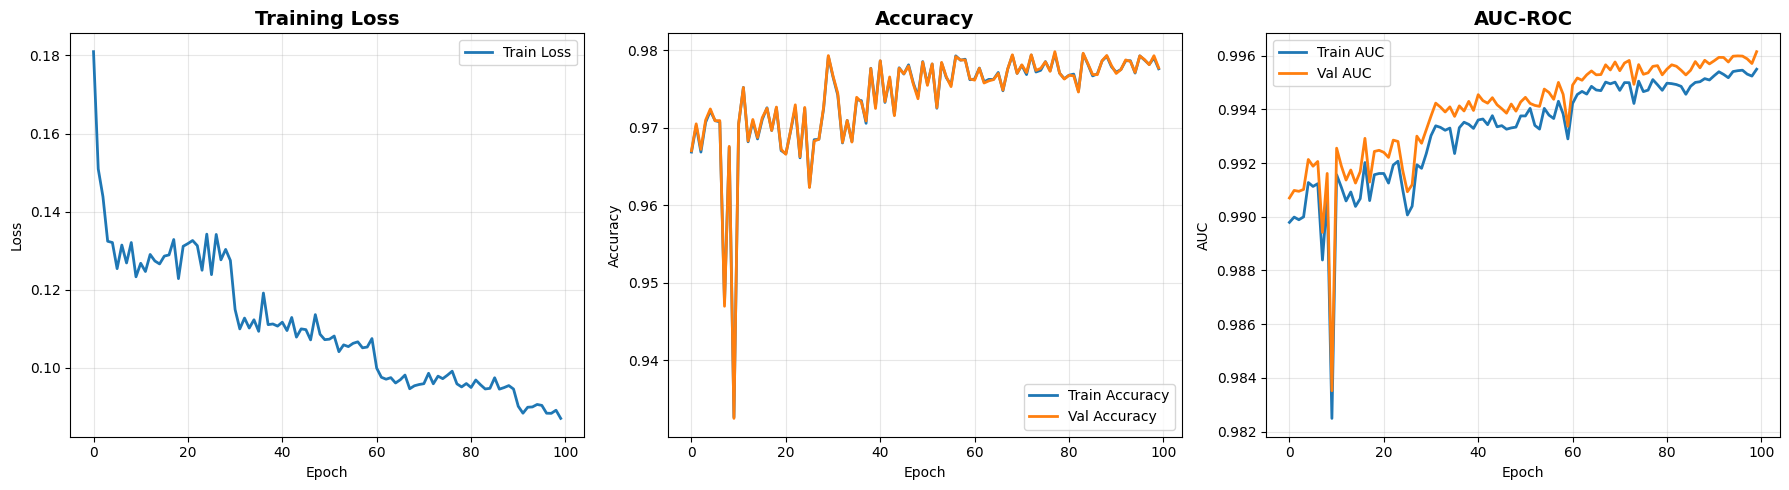

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].set_title('Training Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy
axes[1].plot(train_accs, label='Train Accuracy', linewidth=2)
axes[1].plot(val_accs, label='Val Accuracy', linewidth=2)
axes[1].set_title('Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(alpha=0.3)

# AUC
axes[2].plot(train_aucs, label='Train AUC', linewidth=2)
axes[2].plot(val_aucs, label='Val AUC', linewidth=2)
axes[2].set_title('AUC-ROC', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('AUC')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [53]:
print("\n" + "="*70)
print("TEST SET EVALUATION")
print("="*70)

# test_acc, test_auc, test_pred, test_probs = evaluate(test_mask)
# test_labels = graph_data.y[test_mask].cpu().numpy()

print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_pred, 
                           target_names=['Normal Account', 'High-Risk Account'],
                           digits=4))


TEST SET EVALUATION

Test Accuracy: 0.9766
Test AUC-ROC: 0.9961

Classification Report:
                   precision    recall  f1-score   support

   Normal Account     0.9998    0.9765    0.9880    127109
High-Risk Account     0.2846    0.9818    0.4413      1210

         accuracy                         0.9766    128319
        macro avg     0.6422    0.9792    0.7147    128319
     weighted avg     0.9931    0.9766    0.9829    128319



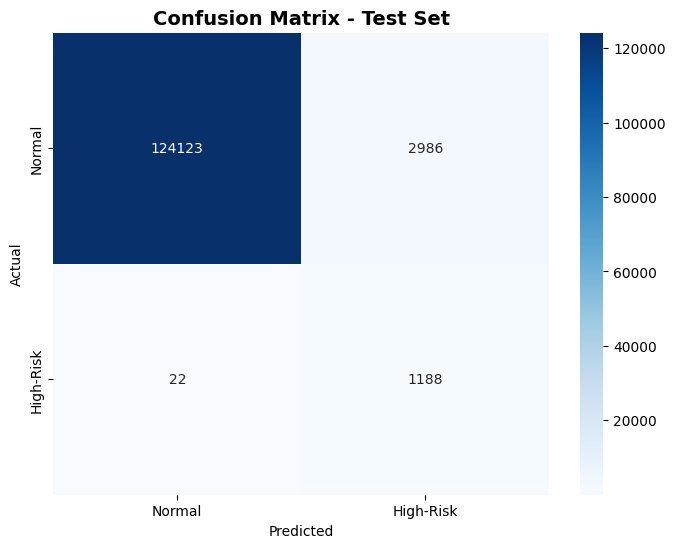

In [54]:
# Confusion Matrix
cm = confusion_matrix(test_labels, test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'High-Risk'],
            yticklabels=['Normal', 'High-Risk'])
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

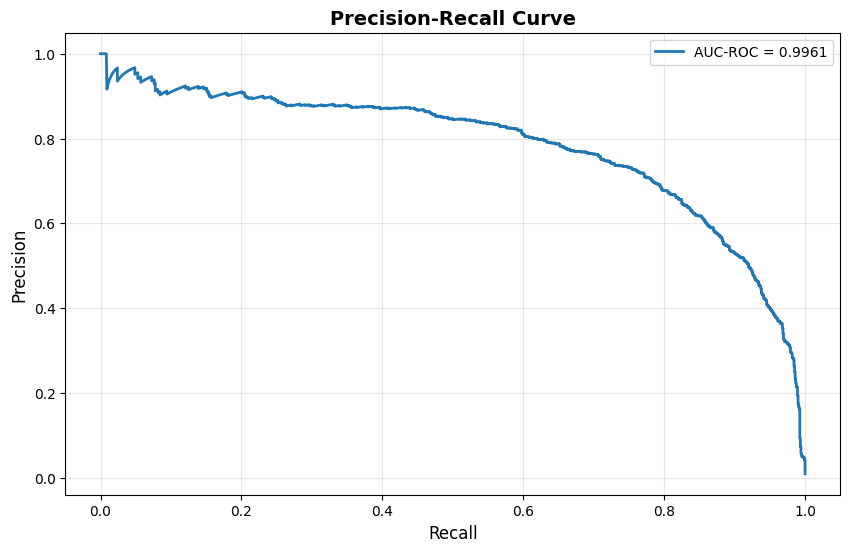

In [55]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(test_labels, test_probs)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, linewidth=2, label=f'AUC-ROC = {test_auc:.4f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

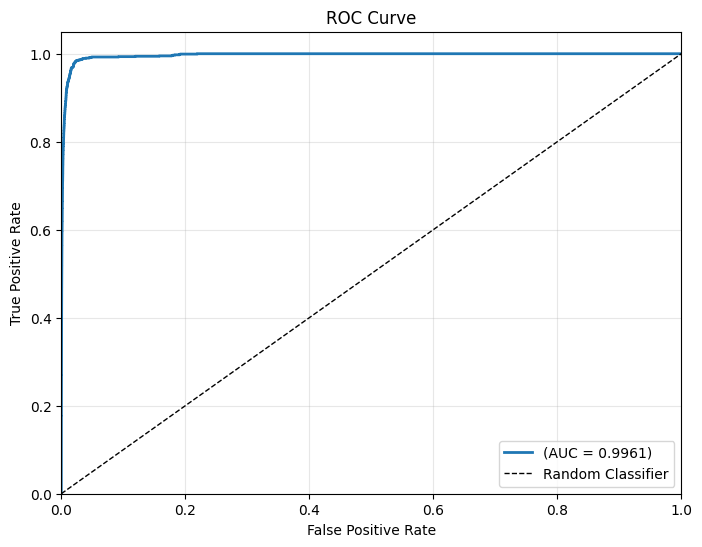

In [56]:
fpr, tpr, thresholds = roc_curve(test_labels, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'(AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### 11. Identify Top High-Risk Accounts

In [35]:
# Get all accounts with risk scores
idx_to_account = {v: k for k, v in account_to_idx.items()}
test_indices = torch.where(test_mask)[0].cpu().numpy()

high_risk_scores = list(zip(test_indices, test_probs))
high_risk_scores.sort(key=lambda x: x[1], reverse=True)

print("\n" + "="*70)
print("TOP 20 HIGH-RISK ACCOUNTS")
print("="*70)
print(f"{'Rank':<6} {'Account ID':<20} {'Risk Score':<12} {'Actual Label':<15} {'Predicted':<12}")
print("-" * 70)

for i, (idx, score) in enumerate(high_risk_scores[:20], 1):
    account_id = idx_to_account[idx]
    test_idx_position = list(test_indices).index(idx)
    actual_label = "HIGH-RISK" if test_labels[test_idx_position] == 1 else "NORMAL"
    predicted = "HIGH-RISK" if test_pred[test_idx_position] == 1 else "NORMAL"
    
    print(f"{i:<6} {str(account_id):<20} {score:<12.4f} {actual_label:<15} {predicted:<12}")


TOP 20 HIGH-RISK ACCOUNTS
Rank   Account ID           Risk Score   Actual Label    Predicted   
----------------------------------------------------------------------
1      8804315251           0.9992       HIGH-RISK       HIGH-RISK   
2      7689874264           0.9992       HIGH-RISK       HIGH-RISK   
3      9876356584           0.9991       HIGH-RISK       HIGH-RISK   
4      3892281356           0.9991       HIGH-RISK       HIGH-RISK   
5      7974286543           0.9990       HIGH-RISK       HIGH-RISK   
6      306007239            0.9990       HIGH-RISK       HIGH-RISK   
7      6353221487           0.9989       HIGH-RISK       HIGH-RISK   
8      3716692127           0.9989       HIGH-RISK       HIGH-RISK   
9      5270630718           0.9987       HIGH-RISK       HIGH-RISK   
10     1048720086           0.9987       HIGH-RISK       HIGH-RISK   
11     6350972201           0.9987       HIGH-RISK       HIGH-RISK   
12     1181210781           0.9987       HIGH-RISK       HIGH-

### 12. Feature Importance Analysis

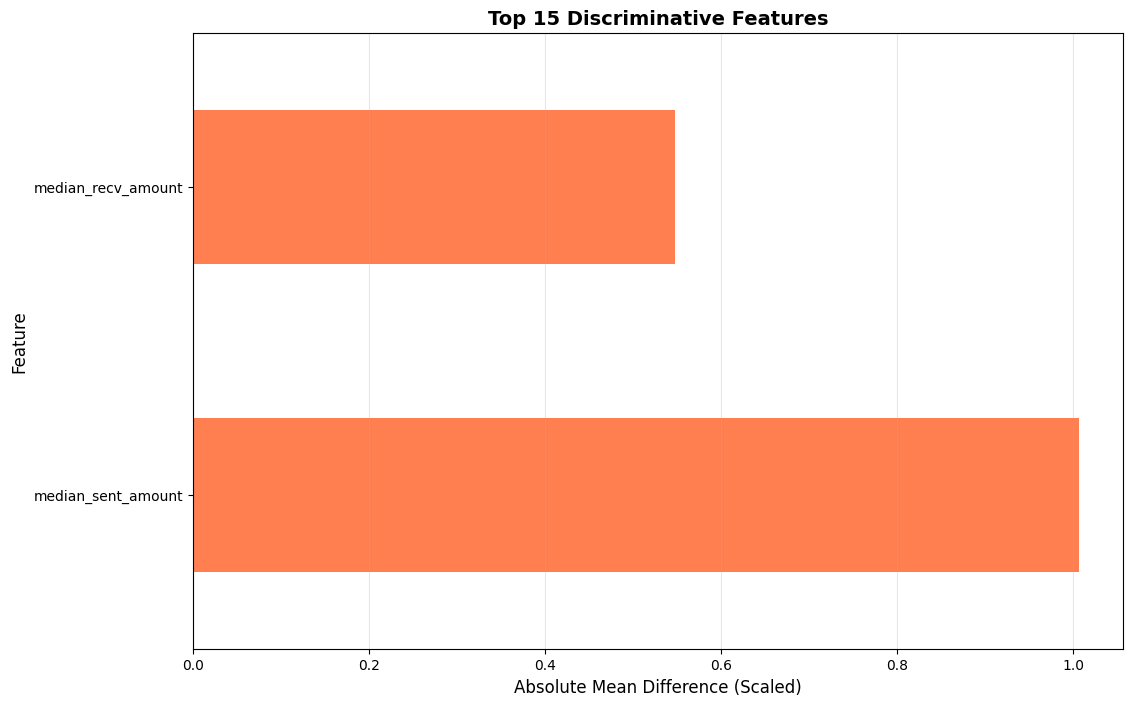

In [57]:
# Get feature importance by analyzing predictions on high-risk vs normal accounts
high_risk_mask = (graph_data.y == 1)
normal_mask = (graph_data.y == 0)

high_risk_features = features_df_scaled[high_risk_mask.cpu().numpy()].mean()
normal_features = features_df_scaled[normal_mask.cpu().numpy()].mean()

feature_diff = (high_risk_features - normal_features).abs().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
feature_diff.head(15).plot(kind='barh', color='coral')
plt.title('Top 15 Discriminative Features', fontsize=14, fontweight='bold')
plt.xlabel('Absolute Mean Difference (Scaled)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout
plt.show()

### 13. Account Profile Analysis

In [38]:
# %%
def analyze_account(account_id):
    """
    Detailed analysis of a specific account
    """
    if account_id not in account_to_idx:
        print(f"Account {account_id} not found in dataset")
        return
    
    idx = account_to_idx[account_id]
    
    # Get prediction
    model.eval()
    with torch.no_grad():
        out = model(graph_data.x, graph_data.edge_index)
        prob = F.softmax(out[idx], dim=0)[1].item()
        pred = out[idx].argmax().item()
    
    actual = graph_data.y[idx].item()
    
    print("\n" + "="*70)
    print(f"ACCOUNT ANALYSIS: {account_id}")
    print("="*70)
    print(f"Risk Score: {prob:.4f}")
    print(f"Predicted: {'HIGH-RISK' if pred == 1 else 'NORMAL'}")
    print(f"Actual: {'HIGH-RISK' if actual == 1 else 'NORMAL'}")
    
    # Get account features
    account_features = features_df.loc[account_id]
    
    print("\n--- Transaction Profile ---")
    print(f"Total Transactions: {int(account_features['total_txns'])}")
    print(f"Sent: {int(account_features['sent_count'])} | Received: {int(account_features['recv_count'])}")
    print(f"Total Sent Amount: ${account_features['total_sent_amount']:,.2f}")
    print(f"Total Received Amount: ${account_features['total_recv_amount']:,.2f}")
    
    print("\n--- Behavioral Patterns ---")
    # print(f"Max Daily Transactions: {int(account_features['max_daily_txn_count'])}")
    # print(f"Avg Daily Transactions: {account_features['avg_daily_txn_count']:.2f}")
    # print(f"Max Weekly Transactions: {int(account_features['max_weekly_txn_count'])}")
    # print(f"Max Monthly Transactions: {int(account_features['max_monthly_txn_count'])}")
    # print(f"Daily Velocity Ratio: {account_features['daily_velocity_ratio']:.2f}")
    # print(f"Active Days Ratio: {account_features['active_days_ratio']:.2%}")
    
    print("\n--- Risk Indicators ---")
    print(f"High-Risk Geography: {int(account_features['sent_to_high_risk'])} transactions")
    print(f"Cash Usage Ratio: {account_features['cash_usage_ratio']:.2%}")
    print(f"Near-Threshold Transactions: {int(account_features['near_threshold_txns'])}")
    print(f"Round Amounts: {int(account_features['round_amounts'])}")
    
    print("\n--- Network Activity ---")
    print(f"Unique Receivers: {int(account_features['unique_receivers'])}")
    print(f"Unique Senders: {int(account_features['unique_senders'])}")
    print(f"Counterparty Diversity: {int(account_features['counterparty_diversity'])}")
    
    # Get actual transactions
    sent_txns = df[df['Sender_account'] == account_id]
    recv_txns = df[df['Receiver_account'] == account_id]
    
    if len(sent_txns) > 0:
        print("\n--- Recent Sent Transactions (Top 5 by Amount) ---")
        print(sent_txns.nlargest(5, 'Amount')[['Timestamp', 'Receiver_account', 'Amount', 
                                                 'Payment_type', 'Is_Suspicious']])
    
    if len(recv_txns) > 0:
        print("\n--- Recent Received Transactions (Top 5 by Amount) ---")
        print(recv_txns.nlargest(5, 'Amount')[['Timestamp', 'Sender_account', 'Amount', 
                                                'Payment_type', 'Is_Suspicious']])


In [39]:
# Example: Analyze a high-risk account
if len(high_risk_scores) > 0:
    top_high_risk_idx = high_risk_scores[0][0]
    top_high_risk_account = idx_to_account[top_high_risk_idx]
    analyze_account(top_high_risk_account)


ACCOUNT ANALYSIS: 3627634017
Risk Score: 0.9996
Predicted: HIGH-RISK
Actual: HIGH-RISK

--- Transaction Profile ---
Total Transactions: 8
Sent: 8 | Received: 0
Total Sent Amount: $78.04
Total Received Amount: $0.00

--- Behavioral Patterns ---

--- Risk Indicators ---
High-Risk Geography: 0 transactions
Cash Usage Ratio: 0.00%


KeyError: 'near_threshold_txns'

In [31]:
# ## 14. Risk Score Distribution

# %%
# Get all risk scores
model.eval()
with torch.no_grad():
    out = model(graph_data.x, graph_data.edge_index)
    all_probs = F.softmax(out, dim=1)[:, 1].cpu().numpy()
all_labels = graph_data.y.cpu().numpy()

# Plot risk score distributions
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(all_probs[all_labels == 0], bins=50, alpha=0.6, label='Normal Accounts', color='green')
axes[0].hist(all_probs[all_labels == 1], bins=50, alpha=0.6, label='High-Risk Accounts', color='red')
axes[0].set_xlabel('Risk Score', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Risk Score Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot
data_for_box = [all_probs[all_labels == 0], all_probs[all_labels == 1]]
bp = axes[1].boxplot(data_for_box, labels=['Normal', 'High-Risk'], patch_artist=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
axes[1].set_ylabel('Risk Score', fontsize=12)
axes[1].set_title('Risk Score by Account Type', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

### 15. Model Performance by Risk Threshold

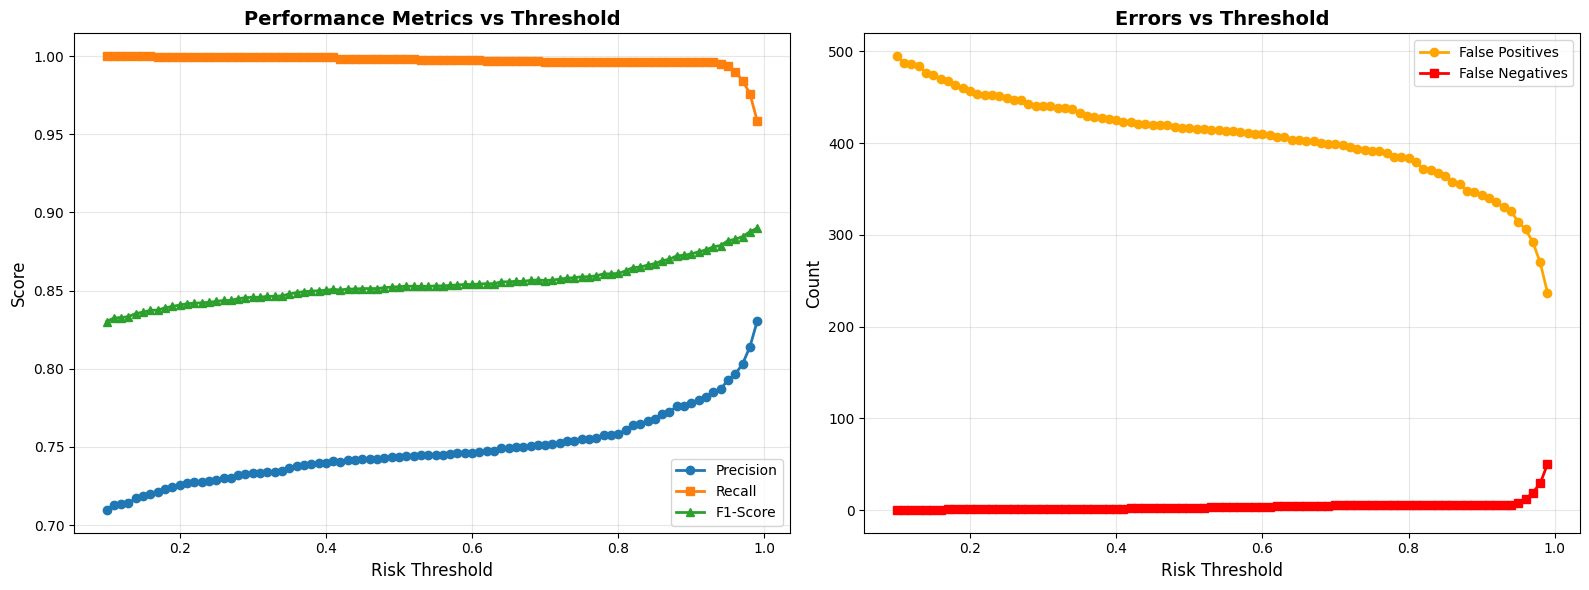


Threshold Analysis:
 threshold  precision   recall       f1   tp  fp  fn
      0.10   0.709677 1.000000 0.830189 1210 495   0
      0.11   0.713023 1.000000 0.832473 1210 487   0
      0.12   0.713443 1.000000 0.832760 1210 486   0
      0.13   0.714286 1.000000 0.833333 1210 484   0
      0.14   0.717250 1.000000 0.835347 1210 477   0
      0.15   0.718527 1.000000 0.836213 1210 474   0
      0.16   0.720238 1.000000 0.837370 1210 470   0
      0.17   0.720930 0.999174 0.837548 1209 468   1
      0.18   0.723086 0.999174 0.839001 1209 463   1
      0.19   0.724386 0.999174 0.839875 1209 460   1
      0.20   0.725690 0.999174 0.840751 1209 457   1
      0.21   0.726999 0.999174 0.841629 1209 454   1
      0.22   0.727437 0.999174 0.841922 1209 453   1
      0.23   0.727875 0.999174 0.842215 1209 452   1
      0.24   0.728313 0.999174 0.842509 1209 451   1
      0.25   0.729192 0.999174 0.843096 1209 449   1
      0.26   0.730072 0.999174 0.843685 1209 447   1
      0.27   0.730072 0.9

In [32]:
# Analyze performance at different thresholds
thresholds = np.arange(0.1, 1.0, 0.01)
threshold_metrics = []

for threshold in thresholds:
    test_pred_threshold = (test_probs >= threshold).astype(int)
    
    # Calculate metrics
    tp = ((test_pred_threshold == 1) & (test_labels == 1)).sum()
    tn = ((test_pred_threshold == 0) & (test_labels == 0)).sum()
    fp = ((test_pred_threshold == 1) & (test_labels == 0)).sum()
    fn = ((test_pred_threshold == 0) & (test_labels == 1)).sum()
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    threshold_metrics.append({
        'threshold': threshold,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': tp,
        'fp': fp,
        'fn': fn
    })

threshold_df = pd.DataFrame(threshold_metrics)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Precision-Recall-F1
axes[0].plot(threshold_df['threshold'], threshold_df['precision'], 
             marker='o', label='Precision', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['recall'], 
             marker='s', label='Recall', linewidth=2)
axes[0].plot(threshold_df['threshold'], threshold_df['f1'], 
             marker='^', label='F1-Score', linewidth=2)
axes[0].set_xlabel('Risk Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Performance Metrics vs Threshold', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# False Positives vs False Negatives
axes[1].plot(threshold_df['threshold'], threshold_df['fp'], 
             marker='o', label='False Positives', linewidth=2, color='orange')
axes[1].plot(threshold_df['threshold'], threshold_df['fn'], 
             marker='s', label='False Negatives', linewidth=2, color='red')
axes[1].set_xlabel('Risk Threshold', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Errors vs Threshold', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nThreshold Analysis:")
print(threshold_df.to_string(index=False))

### 17. Summary and Key Findings

In [33]:
# %%
print("\n" + "="*70)
print("SUMMARY OF RESULTS")
print("="*70)

print(f"\n📊 Dataset Statistics:")
print(f"   • Total Accounts: {len(features_df):,}")
print(f"   • High-Risk Accounts: {labels_series.sum():,} ({labels_series.mean()*100:.2f}%)")
print(f"   • Total Transactions: {len(df):,}")
print(f"   • Graph Edges: {graph_data.num_edges:,}")

print(f"\n🎯 Model Performance (Test Set):")
print(f"   • Accuracy: {test_acc:.4f}")
print(f"   • AUC-ROC: {test_auc:.4f}")

# Calculate additional metrics
test_cm = confusion_matrix(test_labels, test_pred)
tn, fp, fn, tp = test_cm.ravel()
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"   • Precision: {precision:.4f}")
print(f"   • Recall: {recall:.4f}")
print(f"   • F1-Score: {f1:.4f}")
print(f"   • False Positive Rate: {fp/(fp+tn):.4f}")
print(f"   • False Negative Rate: {fn/(fn+tp):.4f}")

print(f"\n🔍 Top Risk Indicators:")
top_features = feature_diff.head(5)
for i, (feat, val) in enumerate(top_features.items(), 1):
    print(f"   {i}. {feat}: {val:.4f}")

print(f"\n💡 Key Insights:")
print(f"   • Behavioral velocity features are strong discriminators")
print(f"   • Network patterns (counterparty diversity) are important")
print(f"   • Geographic and payment type risk contribute to detection")
print(f"   • Graph structure captures money flow relationships")

print("\n" + "="*70)
print("Analysis Complete! ✅")
print("="*70)


SUMMARY OF RESULTS

📊 Dataset Statistics:
   • Total Accounts: 855,460
   • High-Risk Accounts: 7,902 (0.92%)
   • Total Transactions: 9,504,852
   • Graph Edges: 9,504,852

🎯 Model Performance (Test Set):
   • Accuracy: 0.9967
   • AUC-ROC: 0.9993
   • Precision: 0.7438
   • Recall: 0.9983
   • F1-Score: 0.8525
   • False Positive Rate: 0.0033
   • False Negative Rate: 0.0017

🔍 Top Risk Indicators:
   1. std_sent_amount: 2.7686
   2. total_txns: 2.1854
   3. sent_count: 2.1660
   4. sent_recv_ratio: 2.0740
   5. recv_count: 1.7739

💡 Key Insights:
   • Behavioral velocity features are strong discriminators
   • Network patterns (counterparty diversity) are important
   • Geographic and payment type risk contribute to detection
   • Graph structure captures money flow relationships

Analysis Complete! ✅
